# TESTING OUTPUT
In questo notebook viene caricato il modello ottenuto e mostrato l'output di una delle immagini di testing con relative maschere e box individuate.


In [20]:
# Importazione delle librerie
import sys, shutil, os, distutils.core, random, cv2
from google.colab.patches import cv2_imshow
!python -m pip install pyyaml==5.1

# Installazione dei componenti
!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Setup di base
from detectron2.utils.logger import setup_logger
setup_logger()

# Importazione di strumenti utili di Detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog


In [5]:
# Importazione delle immagini
zip_path_test = '/content/drive/MyDrive/Colab Notebooks/testset.zip'

# Paths di destinazione
destination_path = '/content/images'
shutil.unpack_archive(zip_path_test, destination_path)
test_path = destination_path + '/testset'

# Numero di immagini nella directory di testing
count = 0
for path in os.listdir(test_path):
    # Controlla se il path esiste
    if os.path.isfile(os.path.join(test_path, path)) and os.path.join(test_path, path).endswith('.jpg'):
        count += 1
print('TEST SET:')
print('File count in test set directory:', count)

TEST SET:
File count in test set directory: 400


In [6]:
# Definizione delle istanze per il modello
register_coco_instances("my_dataset_test", {}, "/content/images/testset/test.json", "/content/images/testset")

In [7]:
# Definizione delle classi
MetadataCatalog.get("my_dataset_test").thing_classes = ["cable", "tower_lattice", "tower_tucohy", "tower_wooden"]

In [30]:
# Output del modello
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 8
cfg.INPUT.MIN_SIZE_TRAIN = (700,700)
cfg.INPUT.MAX_SIZE_TRAIN = 700
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8  # Numero di esempi di addestramento utilizzati in un'iterazione per aggiornare i pesi del modello
cfg.SOLVER.BASE_LR = 0.1   # Quantità di aggiustamento dei pesi del modello durante ogni iterazione
cfg.SOLVER.MAX_ITER = 10000    # Iterazioni
cfg.SOLVER.STEPS = [1000, 5000]        # Decadimento del learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Numero di proposte di regione d'interesse (RoI) campionate da ogni immagine durante l'addestramento della testa RoI del modello
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 4
cfg.OUTPUT_DIR = '/content/images'

shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/model_final.zip', destination_path)
# Definizione del modello ottenuto per fare inferenza
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path del modello pre allenato
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Valore soglia per la considerazione delle ROI
predictor = DefaultPredictor(cfg)

[02/21 11:10:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/images/model_final.pth ...


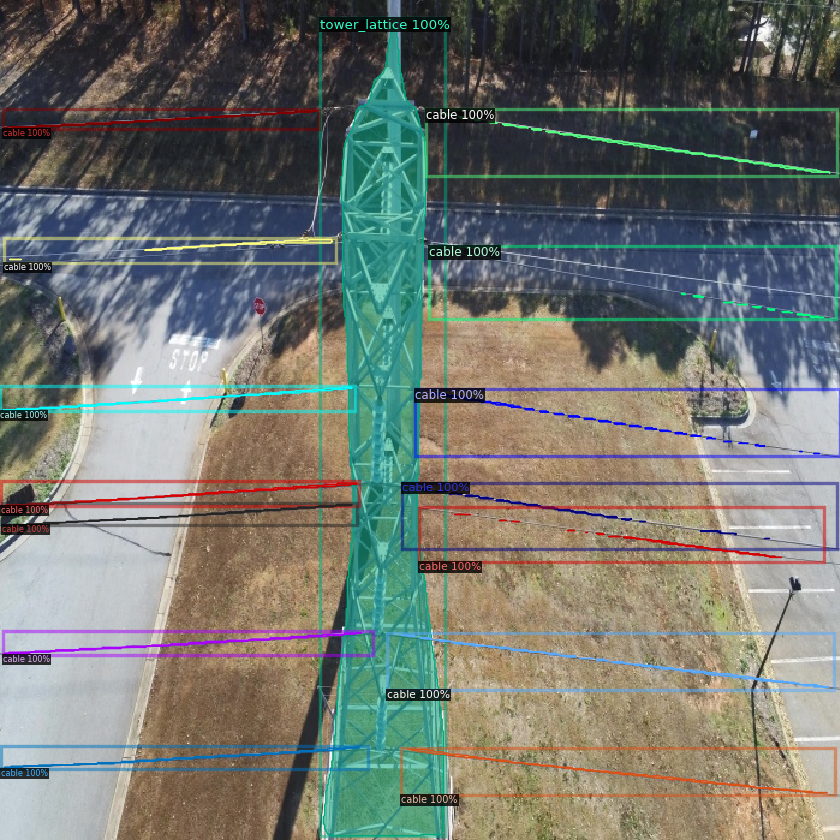

In [44]:
image_source = test_path
elenco_file = os.listdir(image_source)
images = [file for file in elenco_file if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
selected = cv2.imread(os.path.join(image_source, random.choice(images)))
outputs = predictor(selected)

# Usa un visualizzatore per visualizzare le previsioni sull'immagine
v = Visualizer(selected[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Visualizza l'immagine con le previsioni sovrapposte
cv2_imshow( out.get_image()[:, :, ::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()